<a href="https://colab.research.google.com/github/Chris-Congleton/MSc-Thesis/blob/main/Playground/Volkskrant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and loading data

In [1]:
import json, os
import pandas as pd
import nltk
import glob
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
nltk.download('punkt')
import seaborn as sns
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
path_to_json = "gdrive/MyDrive/CS/Thesis/volkskrant-nl"
json_files = ["gdrive/MyDrive/CS/Thesis/volkskrant-nl/"+pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(json_files[:5])

['gdrive/MyDrive/CS/Thesis/volkskrant-nl/volkskrant-nl-2002-01.json', 'gdrive/MyDrive/CS/Thesis/volkskrant-nl/volkskrant-nl-2002-02.json', 'gdrive/MyDrive/CS/Thesis/volkskrant-nl/volkskrant-nl-2002-03.json', 'gdrive/MyDrive/CS/Thesis/volkskrant-nl/volkskrant-nl-2002-04.json', 'gdrive/MyDrive/CS/Thesis/volkskrant-nl/volkskrant-nl-2002-05.json']


In [4]:
def readFiles(file_names):
  dfs = [] # an empty list to store the data frames
  for f in tqdm(file_names):
    data = pd.read_json(f) # read data frame from json file
    dfs.append(data) # append the data frame to the list

  df = pd.concat(dfs, ignore_index=True) # concatenate all the data frames in the list.
  return df

In [5]:
df = readFiles(json_files)
df.shape

100%|██████████| 214/214 [00:40<00:00,  5.26it/s]


(862852, 14)

In [ ]:
df.tail(2)

,categories,cleaned,cleantext,keywords,leading-image,leading-image-caption-content,leading-image-caption-source,leading-image-copyright,og-description,og-image,og-title,timestamp,title,url
862850,Nieuws &amp; Achtergrond,2019-10-16T20:57:04.925000,De nieuwsredactie van de Volkskrant. Beeld Sim...,"[De Volkskrant, economie, business en financië...",https://images4.persgroep.net/rcs/zZXXTbiZRNbQ...,De nieuwsredactie van de Volkskrant.,Beeld Simon Lenskens,Beeld Simon Lenskens,De Volkskrant zoekt freelance-internetredacteu...,https://images4.persgroep.net/rcs/zZXXTbiZRNbQ...,De Volkskrant zoekt internetredacteuren,2019-10-10 07:50:00,De Volkskrant zoekt internetredacteuren,https://www.volkskrant.nl/nieuws-achtergrond/d...
862851,Economie,2019-10-16T22:25:15.752000,Aviko is het tweede grootste aardappelverwerke...,"[Colombia, economie, business en financiën, ec...",https://images0.persgroep.net/rcs/nxqS6pJvbjRy...,Aviko is het tweede grootste aardappelverwerke...,Beeld Hollandse Hoogte / John van Hamond,Beeld Hollandse Hoogte / John van Hamond,Brussel stapt naar de Wereldhandelsorganisatie...,https://images0.persgroep.net/rcs/nxqS6pJvbjRy...,EU naar Wereldhandelsorganisatie wegens Colomb...,2019-10-15 15:10:00,EU naar Wereldhandelsorganisatie wegens Colomb...,https://www.volkskrant.nl/economie/minister-ka...


# Exploratory Data Analysis

Text(0.5, 1.0, 'Total number of articles')

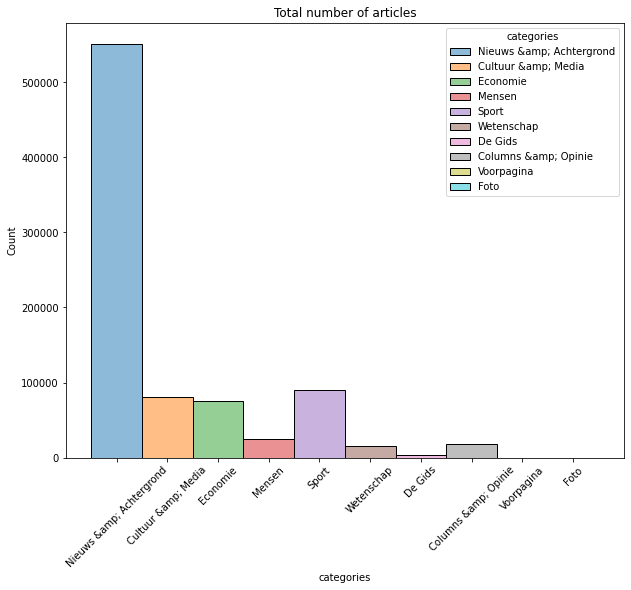

In [ ]:
f, axs = plt.subplots(1,figsize=(10, 8))
sns.histplot(data=df, x="categories", hue="categories", ax=axs)
axs.tick_params(axis='x', rotation=45)
axs.set_title("Total number of articles")

Text(0.5, 1.0, 'Number of articles')

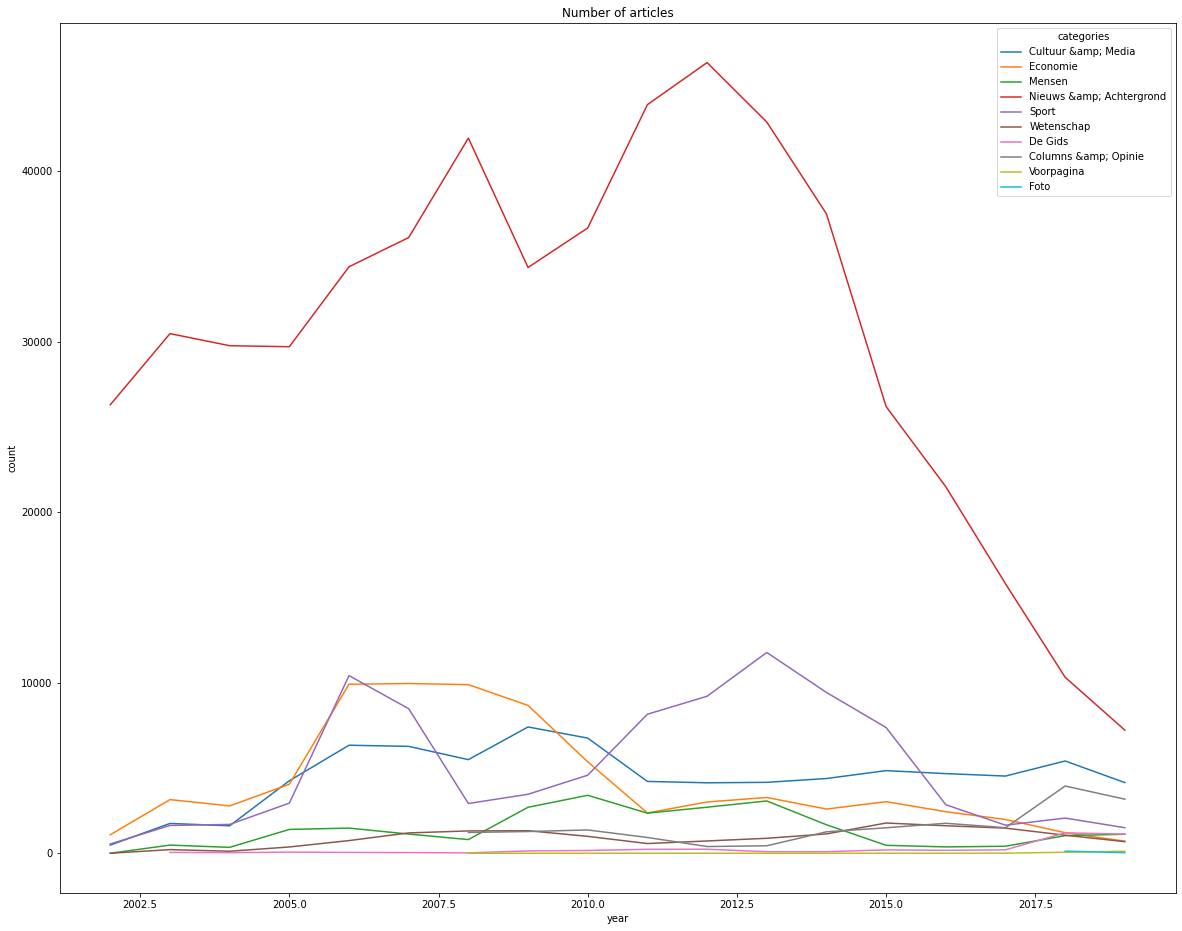

In [ ]:
df_year = df.copy(deep=True)
df_year["year"] = df_year.timestamp.dt.year
time_df = pd.DataFrame({'count':df_year.groupby(["year","categories"]).size()}).reset_index()
f, axs = plt.subplots(1,figsize=(20, 16))
sns.lineplot(data=time_df, x='year',y='count',hue='categories',ci=None, palette=["C0", "C1", "C2", "C3", "C4",
                                                                                 "C5", "C6", "C7", "C8", "C9"])
axs.set_title("Number of articles")

The counts of articles collected per year per category vary quite a bit with for example ~45.000 "News & Background" articles in 2012 and ~10.000 in 2019. These should be normalised when counting party or politician mentions for example. 

Text(0.5, 1.0, 'Total length of articles')

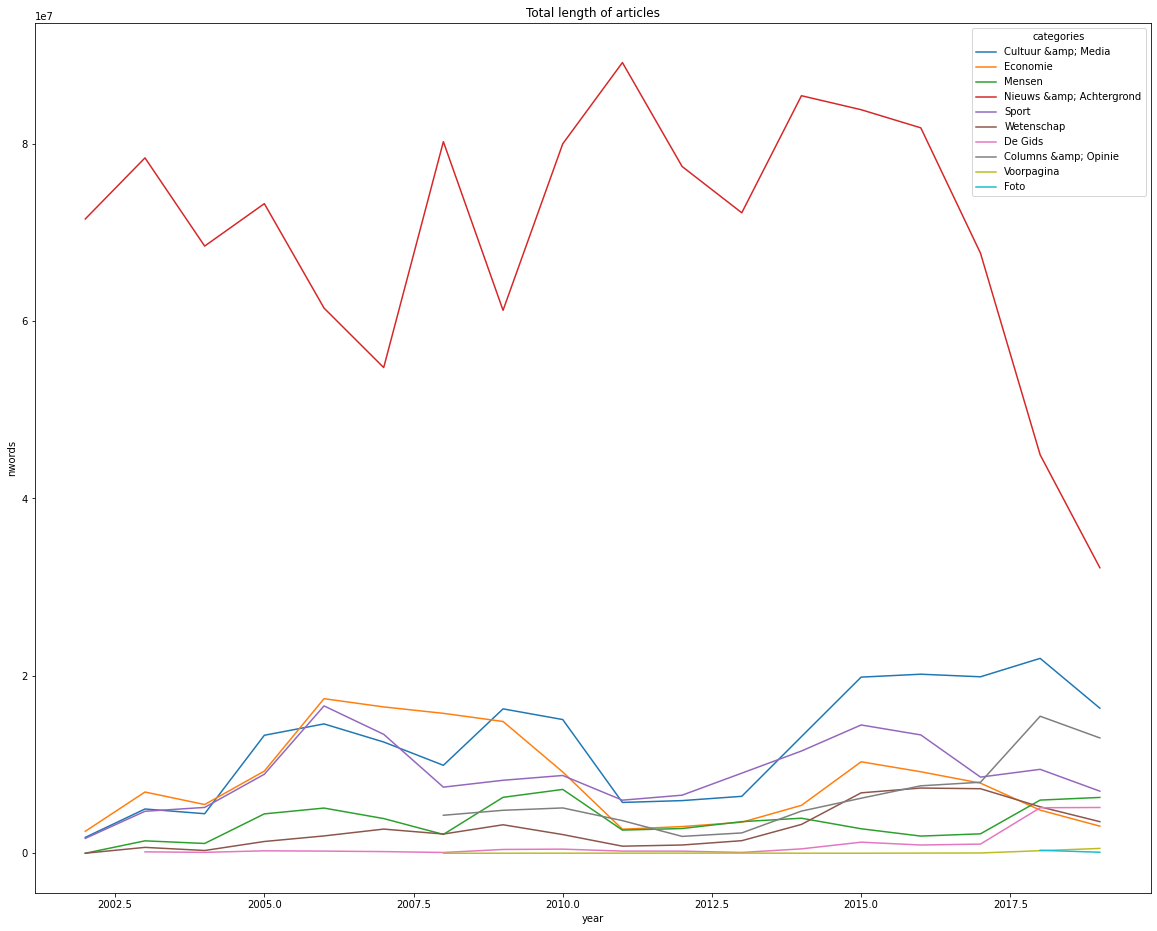

In [ ]:
df_nwords = df.copy(deep=True)
df_nwords["year"] = df_nwords.timestamp.dt.year
df_nwords["nwords"] = df_nwords.cleantext.str.len()
df_nwords = pd.DataFrame(df_nwords.groupby(["year","categories"])["nwords"].agg("sum")).reset_index()

f, axs = plt.subplots(1,figsize=(20, 16))
sns.lineplot(data=df_nwords, x='year',y='nwords',hue='categories',ci=None, palette=["C0", "C1", "C2", "C3", "C4",
                                                                                 "C5", "C6", "C7", "C8", "C9"])
axs.set_title("Total length of articles")

The total amount of words collected is highest for news and background articles. This graph shows a different balance in data.

# Frequentie politieke partijen

In [ ]:
# Lijst partijen tweede kamer per jaar: 
# Bron: https://www.parlement.com/id/vk9scmucgjhj/aantal_deelnemende_partijen_tweede

tk_2002 = ["CDA", "LPF", "VVD", "PvdA", "GL", "SP", "D66", "CU", "SGP", "LN"]
tk_2003 = ["CDA", "LPF", "VVD", "PvdA", "GnL", "SP", "D66", "CU", "SGP"]
tk_2006 = ["CDA", "VVD", "PvdA", "GL", "SP", "D66", "CU", "SGP", "PVV", "PvdD"]
tk_2010 = ["CDA", "VVD", "PvdA", "GL", "SP", "D66", "CU", "SGP", "PVV", "PvdD"]
tk_2012 = ["CDA", "VVD", "PvdA", "GL", "SP", "D66", "CU", "SGP", "PVV", "PvdD", "50PLUS"]
tk_2017 = ["CDA", "VVD", "PvdA", "GL", "SP", "D66", "CU", "SGP", "PVV", "PvdD", "50PLUS", "DENK", "FVD"]
tk_2021 = ["CDA", "VVD", "PvdA", "GL", "SP", "D66", "CU", "SGP", "PVV", "PvdD", "50PLUS", "DENK",
           "FVD", "BIJ1", "BBB", "JA21", "VOLT"]

# Convert to one unique list
tk = [tk_2002, tk_2003,tk_2006,tk_2010,tk_2012,tk_2017,tk_2021]
tk = [item for sublist in tk for item in sublist]
partijen = list(set(tk))
print(partijen)

['DENK', 'PVV', 'GL', 'PvdA', 'LN', 'SP', 'D66', 'VVD', 'SGP', 'BBB', 'VOLT', 'LPF', 'CU', 'CDA', 'FVD', 'GnL', 'BIJ1', '50PLUS', 'PvdD', 'JA21']


In [ ]:
df_partij = df.copy(deep=True)
df_partij["year"] = df_partij.timestamp.dt.year

for p in partijen:
  df_partij[p] = df_partij.cleantext.str.count(p)

df_party_counts = pd.DataFrame()

for p in partijen:
  df_party_counts[p] = df_partij.groupby(["year"])[p].agg("sum")

df_party_counts = df_party_counts.reset_index()
df_mentions = df_party_counts.melt('year')

In [ ]:
df_mentions = df_mentions.rename(columns={'year':'Year','variable':'Party','value':'Frequency'})

# Drop rows where frequency is <1000
df_mentions = df_mentions[df_mentions.Frequency > 1000]
print(df_mentions.head())

    Year Party  Frequency
24  2008   PVV       1253
25  2009   PVV       2907
26  2010   PVV       7906
27  2011   PVV       5907
28  2012   PVV       6330


Text(0.5, 1.0, 'Party mentions in Volkskrant')

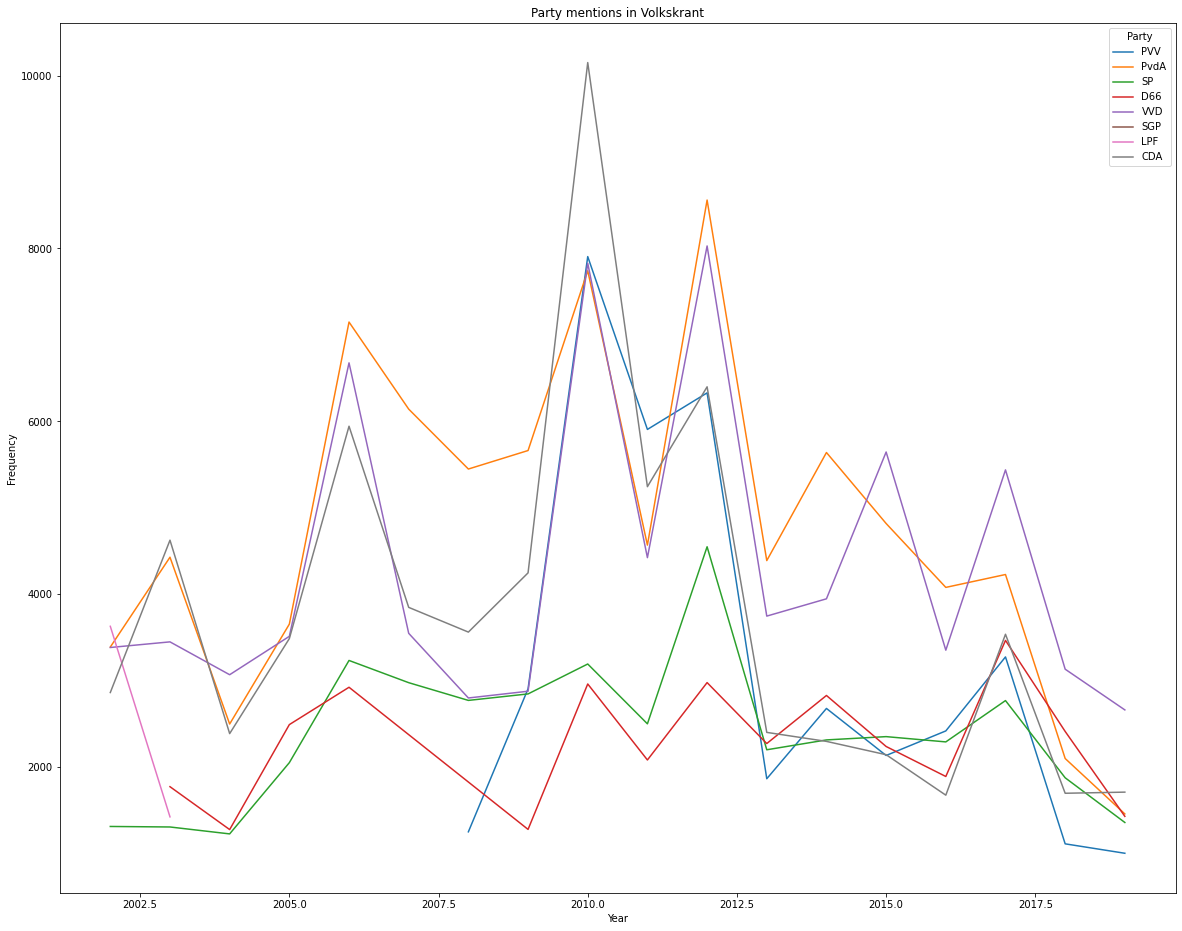

In [ ]:
f, axs = plt.subplots(1,figsize=(20, 16))
sns.lineplot(data=df_mentions, x='Year',y='Frequency', hue='Party')
axs.set_title("Party mentions in Volkskrant")

# Frequentie politici

In [ ]:
politici = ["Kees van der Staaij", "Sigrid Kaag", "Lilian Marijnissen", "Geert Wilders", "Wopke Hoekstra", "Lilianne Ploumen", "Mark Rutte"]

In [ ]:
# Computing number of articles per year to normalise counts
df_norm = time_df.groupby("year").sum("count").reset_index()
df_norm = df_norm.rename(columns={"year":"Year", "count":"Articles"})
print(df_norm.head())

   Year  Articles
0  2002     28425
1  2003     37758
2  2004     36359
3  2005     42793
4  2006     63351


In [ ]:
# Count occurence of politicians
df_politici = df.copy(deep=True)
df_politici["year"] = df_politici.timestamp.dt.year

for p in politici:
  df_politici[p] = df_politici.cleantext.str.count(p)

df_politici_counts = pd.DataFrame()

for p in politici:
  df_politici_counts[p] = df_politici.groupby(["year"])[p].agg("sum")

df_politici_counts = df_politici_counts.reset_index()
df_pol_mentions = df_politici_counts.melt('year')

df_pol_mentions = df_pol_mentions.rename(columns={'year':'Year','variable':'Politician','value':'Frequency'})

df_pol_mentions.tail()

,Year,Politician,Frequency
121,2015,Mark Rutte,1083
122,2016,Mark Rutte,913
123,2017,Mark Rutte,1231
124,2018,Mark Rutte,794
125,2019,Mark Rutte,591


In [ ]:
df_pol_mentions = df_pol_mentions.merge(df_norm, on="Year")
print(df_pol_mentions.head())

   Year           Politician  Frequency  Articles
0  2002  Kees van der Staaij          2     28425
1  2002          Sigrid Kaag          0     28425
2  2002   Lilian Marijnissen          0     28425
3  2002        Geert Wilders          6     28425
4  2002       Wopke Hoekstra          0     28425


   Year           Politician  Frequency  Articles  Normalised Freq
0  2002  Kees van der Staaij          2     28425         0.703606
1  2002          Sigrid Kaag          0     28425         0.000000
2  2002   Lilian Marijnissen          0     28425         0.000000
3  2002        Geert Wilders          6     28425         2.110818
4  2002       Wopke Hoekstra          0     28425         0.000000


Text(0.5, 1.0, 'Politician mentions in Volkskrant (normalised)')

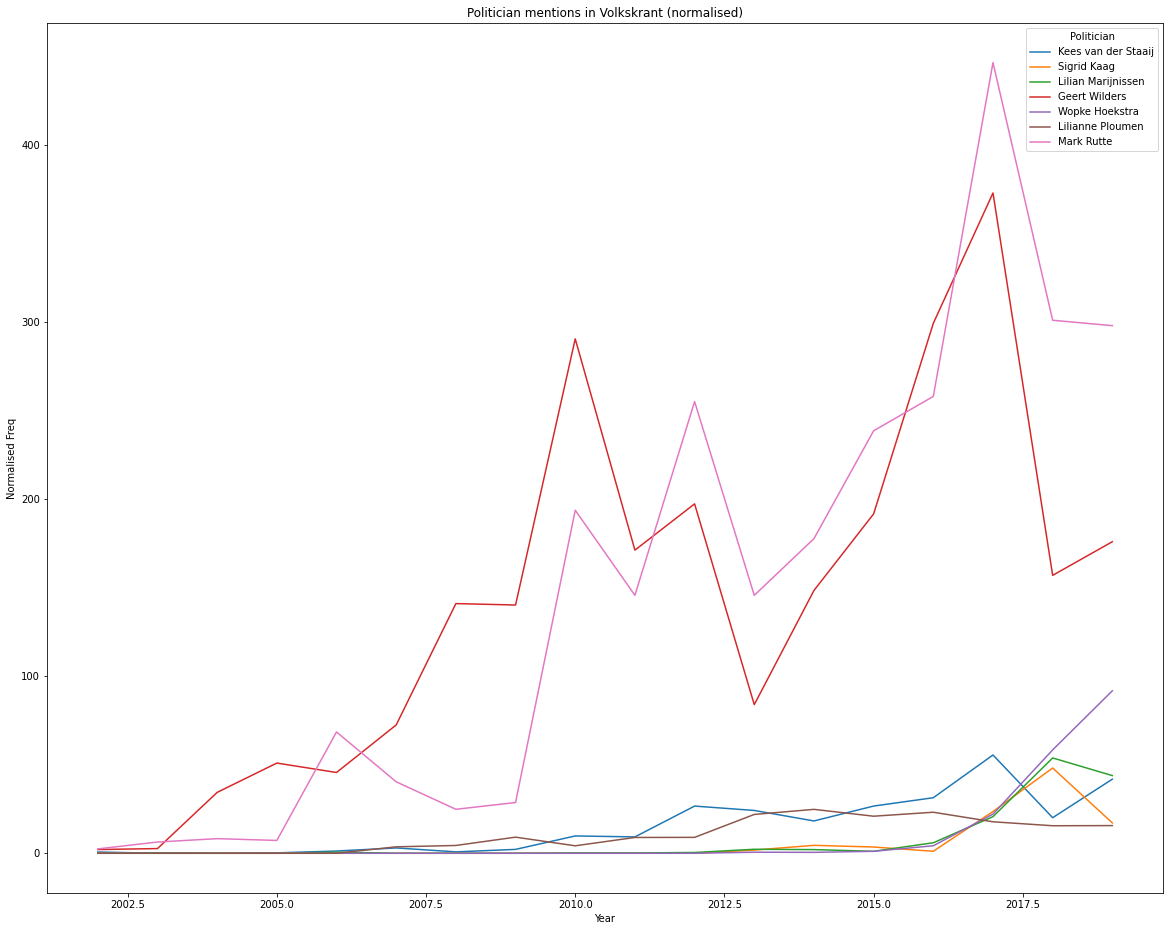

In [ ]:
# Drop rows where frequency is <1000
# df_pol_mentions = df_pol_mentions[df_pol_mentions.Frequency > 1000]
# print(df_pol_mentions.head())
df_pol_mentions["Normalised Freq"] = df_pol_mentions["Frequency"]/df_pol_mentions["Articles"]*10000
print(df_pol_mentions.head())

f, axs = plt.subplots(1,figsize=(20, 16))
sns.lineplot(data=df_pol_mentions, x='Year',y='Normalised Freq', hue='Politician')
axs.set_title("Politician mentions in Volkskrant (normalised)")

# Politici en politieke partijen moving average

In [ ]:
politici = ["Kees van der Staaij", "Sigrid Kaag", "Lilian Marijnissen", "Geert Wilders", "Wopke Hoekstra", "Lilianne Ploumen", "Mark Rutte"]
partijen = ['DENK', 'PVV', 'GL', 'PvdA', 'LN', 'SP', 'D66', 'VVD', 'SGP', 'BBB', 'VOLT', 'LPF', 'CU', 'CDA', 'FVD', 'GL', 'BIJ1', '50PLUS', 'PvdD', 'JA21']
partijen = ['VVD', 'CDA', 'D66', 'PvdA', 'PVV','GL']


In [ ]:
def visualise_frequencies(frame, words, normalisation=True, smoothing=True, title="Title"):
  df = frame.copy(deep=True)
  df["date"] =  df.timestamp.dt.date

  for w in words:
    df[w] = df.cleantext.str.count(w)

  df_word_counts = pd.DataFrame()

  for w in words:
    df_word_counts[w] = df.groupby("date")[w].agg("sum")

  df_word_counts = df_word_counts.reset_index()
  df_word_mentions = df_word_counts.melt("date")

  df_word_mentions = df_word_mentions.rename(columns={'date':'Date','variable':'Word','value':'Frequency'})

  # Normalisation
  if normalisation:
    time_df = pd.DataFrame({'count':df.groupby(["date","categories"]).size()}).reset_index()
    df_norm = time_df.groupby("date").sum("count").reset_index()
    df_norm = df_norm.rename(columns={'date':'Date', 'count':'Articles'})
    df_norm["Articles"]=df_norm.Articles.rolling(365).mean().shift(-182)
    df_word_mentions = df_word_mentions.merge(df_norm,how='left', on="Date")
    df_word_mentions["Normalised_Frequency"] = df_word_mentions["Frequency"]/df_word_mentions["Articles"]*1000
    df_word_mentions['Frequency_Yearly_Average'] = df_word_mentions.Normalised_Frequency.rolling(365).mean().shift(-182)
  
  else:
    df_word_mentions['Frequency_Yearly_Average'] = df_word_mentions.Frequency.rolling(365).mean().shift(-182)
  
  # Set minumum frequency
  #df_word_mentions = df_word_mentions[df_word_mentions.Frequency_Yearly_Average > 5]

  # bigger plot elements suitable for giving talks
  sns.set_context("talk")
  # set figure size
  plt.figure(figsize=(9,6))
  # Time series plot with Seaborn lineplot()
  sns.lineplot(x="Date", y='Frequency_Yearly_Average', hue='Word', 
              data=df_word_mentions, ci=None)
  # axis labels
  plt.xlabel("Date", size=14)
  plt.ylabel("Normalised Yearly Average Frequency", size=14)
  plt.legend(title=title)


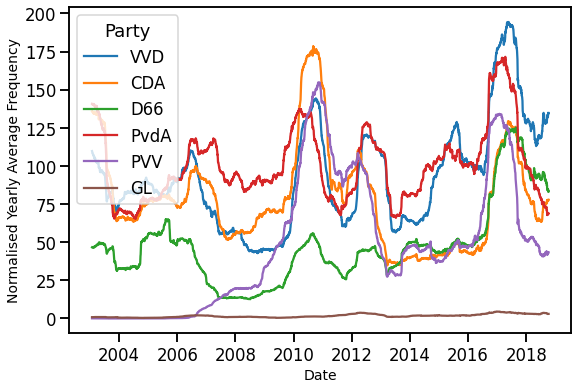

In [ ]:
visualise_frequencies(df, partijen, normalisation=True, title="Party")

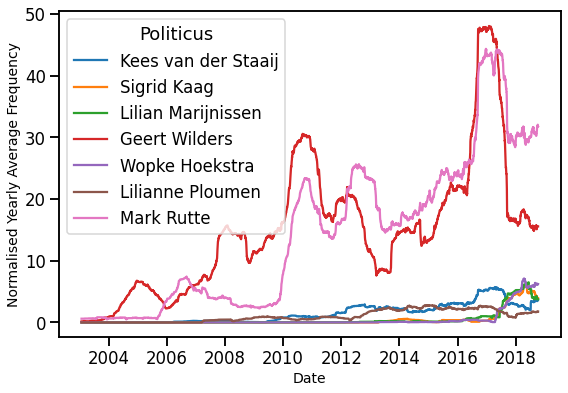

In [ ]:
visualise_frequencies(df, politici, normalisation=True, title="Politicus")

# Alternative terms

In [ ]:
partijen_termen = {'VVD':['VVD', 'Volkspartij voor Vrijheid en Democratie',],
                   'CDA':['CDA', 'Christen-Democratisch Appèl'],
                   'D66':['D66', 'Democraten 66', "D'66"],
                   'PvdA':['PvdA','PVDA', 'Partij van de Arbeid'],
                   'PVV':['PVV', 'Partij voor de Vrijheid'],
                   'GL':['GL', 'GroenLinks']}
print(partijen_termen)

{'VVD': ['VVD', 'Volkspartij voor Vrijheid en Democratie'], 'CDA': ['CDA', 'Christen-Democratisch Appèl'], 'D66': ['D66', 'Democraten 66', "D'66"], 'PvdA': ['PvdA', 'PVDA', 'Partij van de Arbeid'], 'PVV': ['PVV', 'Partij voor de Vrijheid'], 'GL': ['GL', 'GroenLinks']}


In [ ]:
# Visualise frequency of mentions in dataset
# Alternative terms count toward mention
# Terms input through dictionary e.g. {'GL':['GL', 'GroenLinks']}
def visualise_frequencies_at(frame, words, normalisation=True, smoothing=True, title="Title"):
  df = frame.copy(deep=True)
  df["date"] =  df.timestamp.dt.date

  for w in words.keys():
    df[w] = 0
    for term in words[w]:
      df[w] += df.cleantext.str.count(term)

  df_word_counts = pd.DataFrame()

  for w in words:
    df_word_counts[w] = df.groupby("date")[w].agg("sum")

  df_word_counts = df_word_counts.reset_index()
  df_word_mentions = df_word_counts.melt("date")

  df_word_mentions = df_word_mentions.rename(columns={'date':'Date','variable':'Word','value':'Frequency'})

  # Normalisation
  if normalisation:
    time_df = pd.DataFrame({'count':df.groupby(["date","categories"]).size()}).reset_index()
    df_norm = time_df.groupby("date").sum("count").reset_index()
    df_norm = df_norm.rename(columns={'date':'Date', 'count':'Articles'})
    df_norm["Articles"]=df_norm.Articles.rolling(365).mean().shift(-182)
    df_word_mentions = df_word_mentions.merge(df_norm,how='left', on="Date")
    df_word_mentions["Normalised_Frequency"] = df_word_mentions["Frequency"]/df_word_mentions["Articles"]*1000
    df_word_mentions['Frequency_Yearly_Average'] = df_word_mentions.Normalised_Frequency.rolling(365).mean().shift(-182)
  
  else:
    df_word_mentions['Frequency_Yearly_Average'] = df_word_mentions.Frequency.rolling(365).mean().shift(-182)
  
  # Set minumum frequency
  df_word_mentions = df_word_mentions[df_word_mentions.Frequency_Yearly_Average > 10]

  # bigger plot elements suitable for giving talks
  sns.set_context("talk")
  # set figure size
  plt.figure(figsize=(9,6))
  # Time series plot with Seaborn lineplot()
  sns.lineplot(x="Date", y='Frequency_Yearly_Average', hue='Word', 
              data=df_word_mentions, ci=None)
  # axis labels
  plt.xlabel("Date", size=14)
  plt.ylabel("Normalised Yearly Average Frequency", size=14)
  plt.legend(title=title)


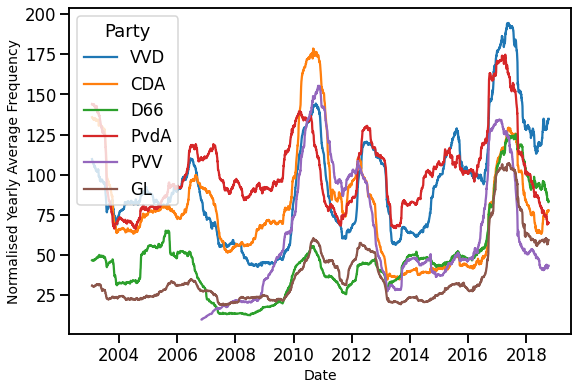

In [ ]:
visualise_frequencies_at(df, partijen_termen, normalisation=True, title="Party")

# Word2vec

In [ ]:
from gensim.parsing.preprocessing import preprocess_string
from gensim import utils
import gensim.models
from tqdm import tqdm

In [ ]:
volkskrant_corpus = list(df["cleantext"].values[:10000])
print(len(volkskrant_corpus))

def corpus_length(corpus):
  i = 0
  for line in tqdm(volkskrant_corpus):
    i += len(utils.simple_preprocess(line))

  print(i)
  return i

corp_length = corpus_length(volkskrant_corpus)

10000


100%|██████████| 10000/10000 [00:05<00:00, 1728.00it/s]

4294362


In [ ]:
class VolkskrantCorpus():
    """An iterator that yields sentences (lists of str)."""

    def __init__(self, corpus):
      self.corpus = corpus

    def __iter__(self):
        for line in self.corpus:
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

In [ ]:
# Training full corpus 60 hours
sentences = VolkskrantCorpus(volkskrant_corpus)
model = gensim.models.Word2Vec(sentences=tqdm(sentences, total=corp_length))

  0%|          | 10000/4294362 [00:07<55:44, 1280.93it/s]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



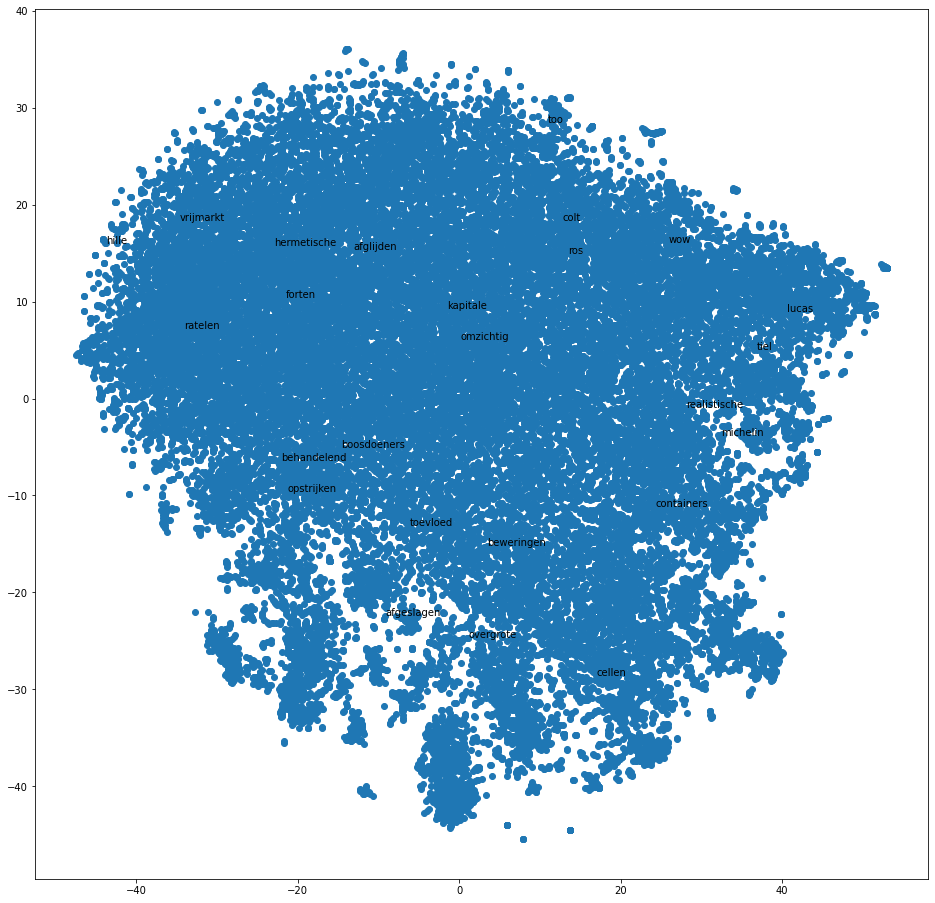

In [ ]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling
import IPython


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2word)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(16, 16))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

plot_function = plot_with_matplotlib

plot_function(x_vals, y_vals, labels)

In [ ]:
import tempfile

with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    model.save(temporary_filepath)
    # The model is now safely stored in the filepath.
    # You can copy it to other machines, share it with others, etc.

In [ ]:
# To load a saved model:
new_model = gensim.models.Word2Vec.load(temporary_filepath)

# LDA

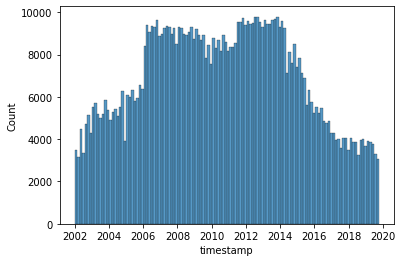

In [6]:
sns.histplot(data=df, x='timestamp')

In [7]:
!pip install -U gensim
!pip install pyLDAvis

import json, os
import pandas as pd
import nltk
import glob
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
nltk.download('punkt')

# regular expression library
import re
# wordcloud library
from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')

import gensim.corpora as corpora

import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [19]:
# Remove the columns
articles = df.drop(columns=['categories', 'cleaned', 'keywords', 'leading-image',
       'leading-image-caption-content', 'leading-image-caption-source',
       'leading-image-copyright', 'og-description', 'og-image', 'og-title', 'url'], axis=1).sample(n=100000, random_state=17)# Print out the first rows of papers
articles.head()

,cleantext,timestamp,title
248614,Gelukkig maar. Mijn geloof kreeg ik met de pap...,2007-08-16 22:00:00,Steun
667277,1995 De politie in Singapore arresteert 14 mat...,2014-04-04 22:00:00,Jarenlange jacht van politie en justitie
846929,Timmermans sprak op 16 februari tijdens een co...,2019-02-22 10:51:00,Timmermans geïntimideerd door Hongaren met cam...
86896,Volgens Martin Hill van Amnesty werd Mohamed Y...,2004-07-28 16:32:45,Afgewezen Somalische asielzoekers vermoord
792584,Beeld de Volkskrant Gelukkig is het helemaal...,2017-02-12 18:30:00,"Mannen kunnen niet nadenken, maar ze zijn wel ..."


In [20]:
# Remove punctuation
articles['cleantext_processed'] = \
articles['cleantext'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
articles['cleantext_processed'] = \
articles['cleantext_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
articles['cleantext_processed'].head()

<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<ipython-input-20-341723ed8bf8>:2: DeprecationWarning: invalid escape sequence \.
  articles['cleantext_processed'] = articles['cleantext'].map(lambda x: re.sub('[,\.!?]', '', x))


248614    gelukkig maar mijn geloof kreeg ik met de papl...
667277    1995 de politie in singapore arresteert 14 mat...
846929    timmermans sprak op 16 februari tijdens een co...
86896     volgens martin hill van amnesty werd mohamed y...
792584    beeld de volkskrant   gelukkig is het helemaal...
Name: cleantext_processed, dtype: object

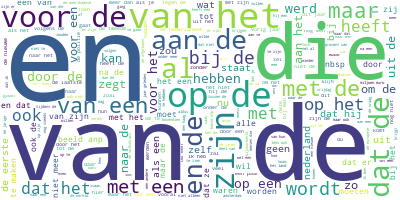

In [11]:
# Join the different processed titles together.
long_string = ','.join(list(articles['cleantext_processed'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [21]:
stop_words.extend(['nbsp', 'rsquo', 'lsquo','euml', 'rdquo', 'quot', 'ldquo' ])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = articles.cleantext_processed.values.tolist()
data_words = list(sent_to_words(data))# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['gelukkig', 'geloof', 'kreeg', 'paplepel', 'ingegoten', 'hoort', 'natuurlijk', 'manier', 'krijg', 'mensen', 'gek', 'aanvankelijk', 'prima', 'geloof', 'problemen', 'mee', 'leven', 'vol', 'goed', 'gedrag', 'hemel', 'komen', 'rond', 'wel', 'bezwaarlijk', 'vond', 'iedere', 'zondag', 'twee', 'keer']


In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [27]:
# number of topics
num_topics = 11
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
doc_lda = lda_model[corpus]

In [28]:
def terms_topics_frame(terms):

  df = pd.DataFrame(data=None)

  for t in terms:
    df_t_topics = pd.DataFrame(lda_model.get_term_topics(t, minimum_probability=0.000000001))
    df_t_topics = df_t_topics.drop(columns=0)
    df_t_topics = df_t_topics.rename(columns={1:t})
    df = pd.concat([df, df_t_topics], axis=1)
  
  return df


In [29]:
df_tt = terms_topics_frame(['vvd', 'pvv', 'fvd', 'pvda', 'sp', 'gl'])
df_tt['topic'] = df_tt.index
df_tt.head()

,vvd,pvv,fvd,pvda,sp,gl,topic
0,5.296059e-05,4.108577e-05,0.000094,1.051236e-04,7.501533e-05,1.886798e-05,0
1,1.566788e-07,8.695393e-07,NaN,7.214515e-08,2.975406e-06,1.048350e-06,1
2,6.474615e-06,3.274066e-03,NaN,9.663244e-06,2.820686e-03,1.133529e-08,2
3,6.121919e-03,1.300261e-05,NaN,6.382512e-03,7.360006e-05,NaN,3
4,1.646518e-04,2.431703e-07,NaN,2.094408e-04,2.165067e-08,NaN,4


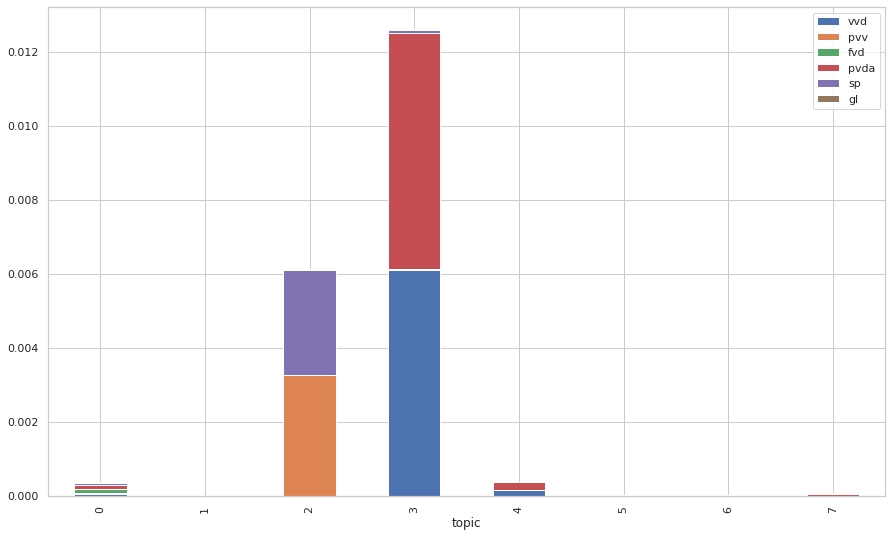

In [30]:
sns.set_theme(style="whitegrid")

# Plot the topic dist per term
df_tt.set_index('topic').plot(kind='bar', stacked=True)
sns.set(rc={'figure.figsize':(15,9)})

In [31]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
LDAvis = gensimvis.prepare(lda_model, corpus, id2word)

LDAvis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.033614  0.100472       1        1  29.078464
6     -0.118627  0.037006       2        1  12.996952
4      0.162905  0.069876       3        1   9.989671
0     -0.069668  0.044156       4        1   9.460872
5     -0.035633  0.162179       5        1   7.442376
9      0.111501 -0.071485       6        1   5.753849
10    -0.165121 -0.037334       7        1   5.520091
1     -0.162849 -0.030534       8        1   5.453123
8      0.118801 -0.126864       9        1   5.446785
7      0.159133  0.027782      10        1   5.196908
2     -0.034056 -0.175256      11        1   3.660910, topic_info=          Term          Freq         Total Category  logprob  loglift
1207   procent  45949.000000  45949.000000  Default  30.0000  30.0000
1280       the  25822.000000  25822.000000  Default  29.0000  29.0000
325      beeld  75335.000000  75335.000000  Default  28.0000  28.0000
440    volgens  54701.000000  54701.000000  Default  27.0000  27.0000
508   function  15695.000000  15695.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
343       drie   1795.653229  30628.266177  Topic11  -5.9833   0.4709
361      grote   1816.851118  36106.113668  Topic11  -5.9716   0.3181
1161    werden   1724.910606  19253.724494  Topic11  -6.0235   0.8949
386     nieuwe   1773.345600  43484.087668  Topic11  -5.9958   0.1079
838        weg   1685.799764  20511.410927  Topic11  -6.0465   0.8087

[1054 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
7467      1  0.015672  aandeel
7467      2  0.920558  aandeel
7467      3  0.010970  aandeel
7467      4  0.000313  aandeel
7467      5  0.000313  aandeel
...     ...       ...      ...
1686      7  0.066160     zuid
1686      8  0.009761     zuid
1686      9  0.050855     zuid
1686     10  0.026151     zuid
1686     11  0.076765     zuid

[4925 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 5, 1, 6, 10, 11, 2, 9, 8, 3])